# "a" consistency

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.style.use('seaborn-muted')
sns.set(style="whitegrid")

%matplotlib inline

In [2]:
import bz2
import os
import ujson
import attr

import pandas as pd
import numpy as np
import statsmodels.api as sm

from glob import glob
from collections import Counter, UserDict
from itertools import islice
from tqdm import tqdm

/Users/dclure/Projects/lint-analysis/env/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
@attr.s
class Dataset:
    
    root = attr.ib()
    
    def paths(self):
        return glob(os.path.join(self.root, '*.bz2'))
    
    def novels(self):
        for path in tqdm(self.paths()):
            with bz2.open(path) as fh:
                for line in fh:
                    yield ujson.loads(line)

In [4]:
ds = Dataset('../../data/top200-100b.json/')

In [5]:
counts = np.array([
    np.array(novel['counts']['a'])
    for novel in ds.novels()
    if novel['word_count'] > 50000 and min(novel['counts']['a'])
])

100%|██████████| 100/100 [00:59<00:00,  1.67it/s]


In [6]:
counts_rel = counts / counts.mean(1, keepdims=True)

In [7]:
def lin_reg(counts):
    x = np.arange(len(counts))
    x = sm.add_constant(x)
    reg = sm.OLS(counts, x)
    return reg, reg.fit()

In [8]:
def plot_lin_reg(reg, fit):
    
    pred = fit.predict()
    x1 = reg.exog[0][1]
    x2 = reg.exog[-1][1]
    y1 = pred[0]
    y2 = pred[-1]
    
    plt.figure(figsize=(4,2))
    plt.plot([x1, x2], [y1, y2], color='gray', linewidth=0.5)
    plt.plot(reg.endog)
    plt.show()

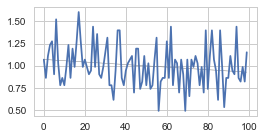

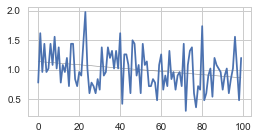

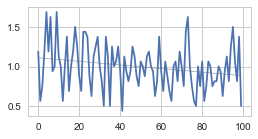

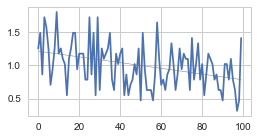

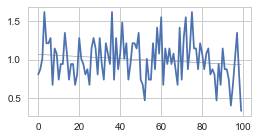

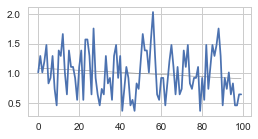

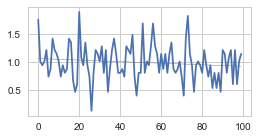

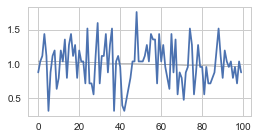

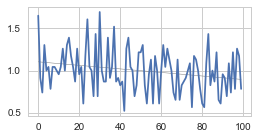

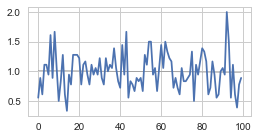

In [9]:
for c in counts_rel[:10]:
    plot_lin_reg(*lin_reg(c))

In [55]:
fits = []
for c in tqdm(counts_rel):
    reg, fit = lin_reg(c)
    fits.append((fit.params[1], fit.pvalues[1]))

100%|██████████| 19484/19484 [00:08<00:00, 2173.41it/s]


In [56]:
fits = pd.DataFrame(fits, columns=('coef', 'p'))

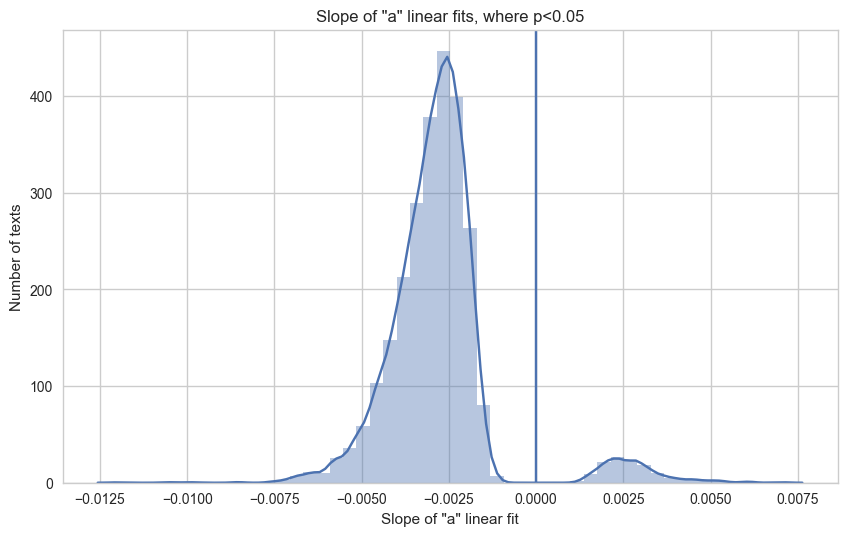

In [71]:
plt.figure(figsize=(10,6), dpi=100)
sns.distplot(fits[fits.p<0.05].coef)
plt.title('Slope of "a" linear fits, where p<0.05')
plt.xlabel('Slope of "a" linear fit')
plt.ylabel('Number of texts')
plt.axvline(x=0)

# Falling "a"

In [12]:
len(fits[(fits['coef'] < 0)]) / len(fits)

0.8213405871484295

In [13]:
len(fits[(fits['coef'] < 0) & (fits['p'] < 0.05)]) / len(fits)

0.3742044754670499

In [14]:
len(fits[(fits['coef'] < 0) & (fits['p'] < 0.01)]) / len(fits)

0.23706631081913365

# Rising "a'

In [15]:
len(fits[(fits['coef'] > 0)]) / len(fits)

0.17865941285157053

In [16]:
len(fits[(fits['coef'] > 0) & (fits['p'] < 0.05)]) / len(fits)

0.019143912954218845

In [17]:
len(fits[(fits['coef'] > 0) & (fits['p'] < 0.01)]) / len(fits)

0.007082734551426812

In [21]:
len(counts)

19484

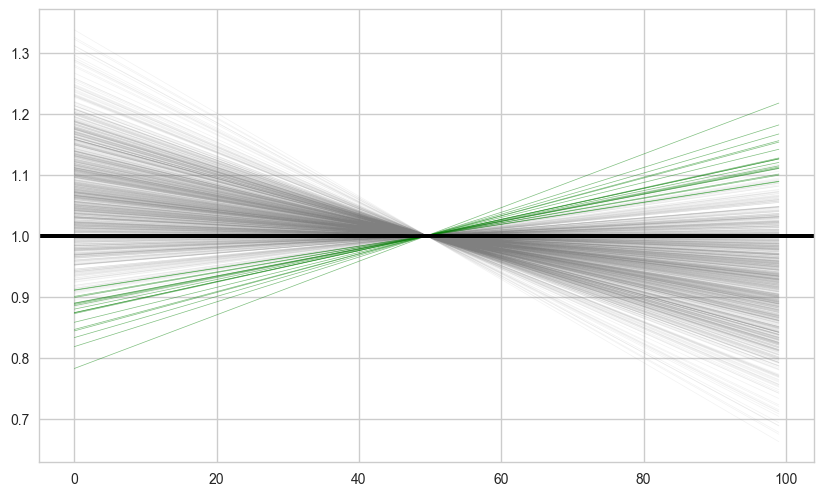

In [46]:
plt.figure(figsize=(10,6), dpi=100)

for c in counts_rel[:1000]:
    
    reg, fit = lin_reg(c)
    
    pred = fit.predict()
    x1 = reg.exog[0][1]
    x2 = reg.exog[-1][1]
    y1 = pred[0]
    y2 = pred[-1]
    
    color = 'gray'
    alpha = 0.1
    linewidth = 0.5
    
    if fit.params[1] > 0 and fit.pvalues[1] < 0.05:
        color = 'green'
        alpha = 0.5
        linewidth = 0.5
    
    plt.plot([x1, x2], [y1, y2], color=color, linewidth=linewidth, alpha=alpha)
    plt.axhline(1, 0, 100, c='black')